In [13]:
import nibabel as nib
import os
import numpy as np
import os.path as op
import scipy
import pandas as pd
import pickle
import scipy.stats
from ipyparallel import Client
from statsmodels.formula.api import ols
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from sklearn import manifold
from sklearn.decomposition import PCA
import seaborn as sns
import moss
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests, fdrcorrection
%matplotlib inline

In [226]:
rc = Client()

In [7]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)

In [32]:
masks = ['yeo17_ifs','hipp','peri_sim','para_sim','mOFC_fill_sim']
roi_names = {'V1_V2':'V1/V2',
             'V1':'V1',
             'para_sim':'PHc',
             'parahippocampal':'PHc',
             'thalamus':'thalamus',
             'sim_4mm_striatum_limbic_func_space':'striatum',
             'peri_sim':'PRc',
             'perirhinal':'PRc',
             'hipp':'Hippocampus',
             'mOFC_fill_sim':'mOFC',
            'yeo17_ifs':'IFS'}
exp = 'sim_4mm-betas'
smooth = 'smoothed'
conds = ['b_plus','b_minus','c_plus','c_minus']
name_map = {'b_plus':'AB+_', 'c_minus':'AC-_','b_minus':'B-_','c_plus':'C+_'}
cond_map = {1:'b_plus',2:'c_minus',3:'b_minus',4:'c_plus'}
nconds = len(cond_map.keys())

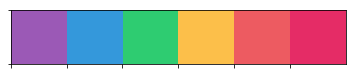

In [9]:
flatui = ["#9b59b6", "#3498db", "#2ecc71","#fcbf4a", "#ed5b61", "#e52c66"]
sns.palplot(sns.color_palette(flatui))

In [10]:
#project a onto b
def vector_reject(a,b): #a gives variance to be
    return a - (np.dot(a,b)/np.dot(b,b)) * b   

# Load and visualize RSA data

In [324]:
#load RSAs from disk
all_rsas = []
for sub in subs:
    out_f = op.join(home_dir,'rsa', sub + 'rsa_sim_OFC.pkl')
    rsa = pd.read_pickle(out_f)
    all_rsas.append(rsa)
all_rsas = pd.concat(all_rsas)

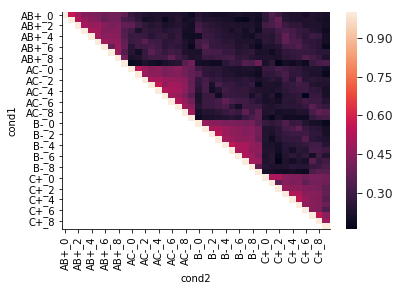

In [19]:
#plot RSA
fig_rsas = all_rsas.set_index(['mask','run','sub']).sort_index()
roi = 'hipp'
run = 2
plt.title('')
sns.set_context('paper',font_scale = 1.4,rc={"figure.figsize": (20, 20)})
sns.set_style("white")

mean_rsa = fig_rsas.loc[roi,run].groupby(['cond1','cond2']).mean().sort_index()
mean_rsa = mean_rsa.unstack()['corr']
sns.heatmap(mean_rsa, vmax = 1)
sns.despine()

plt.savefig('/home/iballard/Dropbox/fd/figs/committee_meeting/' + roi + '.svg',dpi = 600)

# Plot mean RSA for each condition pair

In [341]:
m = model.copy().reset_index()
m = m[m['mask'] != 'V1']
m = m.set_index(['mask','sub']).sort_index()
for row in set(m.index):
    
    df = m.loc[row]
    #+ response + valence + pe + value_next + 
    model_str = 'corr ~ 1 + time  + time2 + C(run,Sum)'

    fit = ols(model_str,df).fit()
    m.loc[row,'resid'] = fit.resid.values

In [342]:
m = m.reset_index().set_index(['mask','run','sub']).sort_index()

In [350]:
#average RSA by block
results= []
for row in set(m.index):
    roi, run, sub = row
    data = m.loc[row].reset_index()
    data['trial1'] = [x.split('_')[1] for x in data['cond1']]
    data['trial2'] = [x.split('_')[1] for x in data['cond2']]
    data['cond1'] = [x.split('_')[0] for x in data['cond1']]
    data['cond2'] = [x.split('_')[0] for x in data['cond2']]

    data = data.set_index(['cond2','cond1'])

    for row2 in set(data.index):
        if True:#row2[0] == row2[1]:
            df = pd.DataFrame({'roi':roi, 'sub':sub, 'run':run}, index = [0])
            val = data.loc[row2].mean()['corr']

            df['r'] = val
            df['comparison'] = row2[0] + '_' + row2[1]
            results.append(df.copy())
results = pd.concat(results)


/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  app.launch_new_instance()


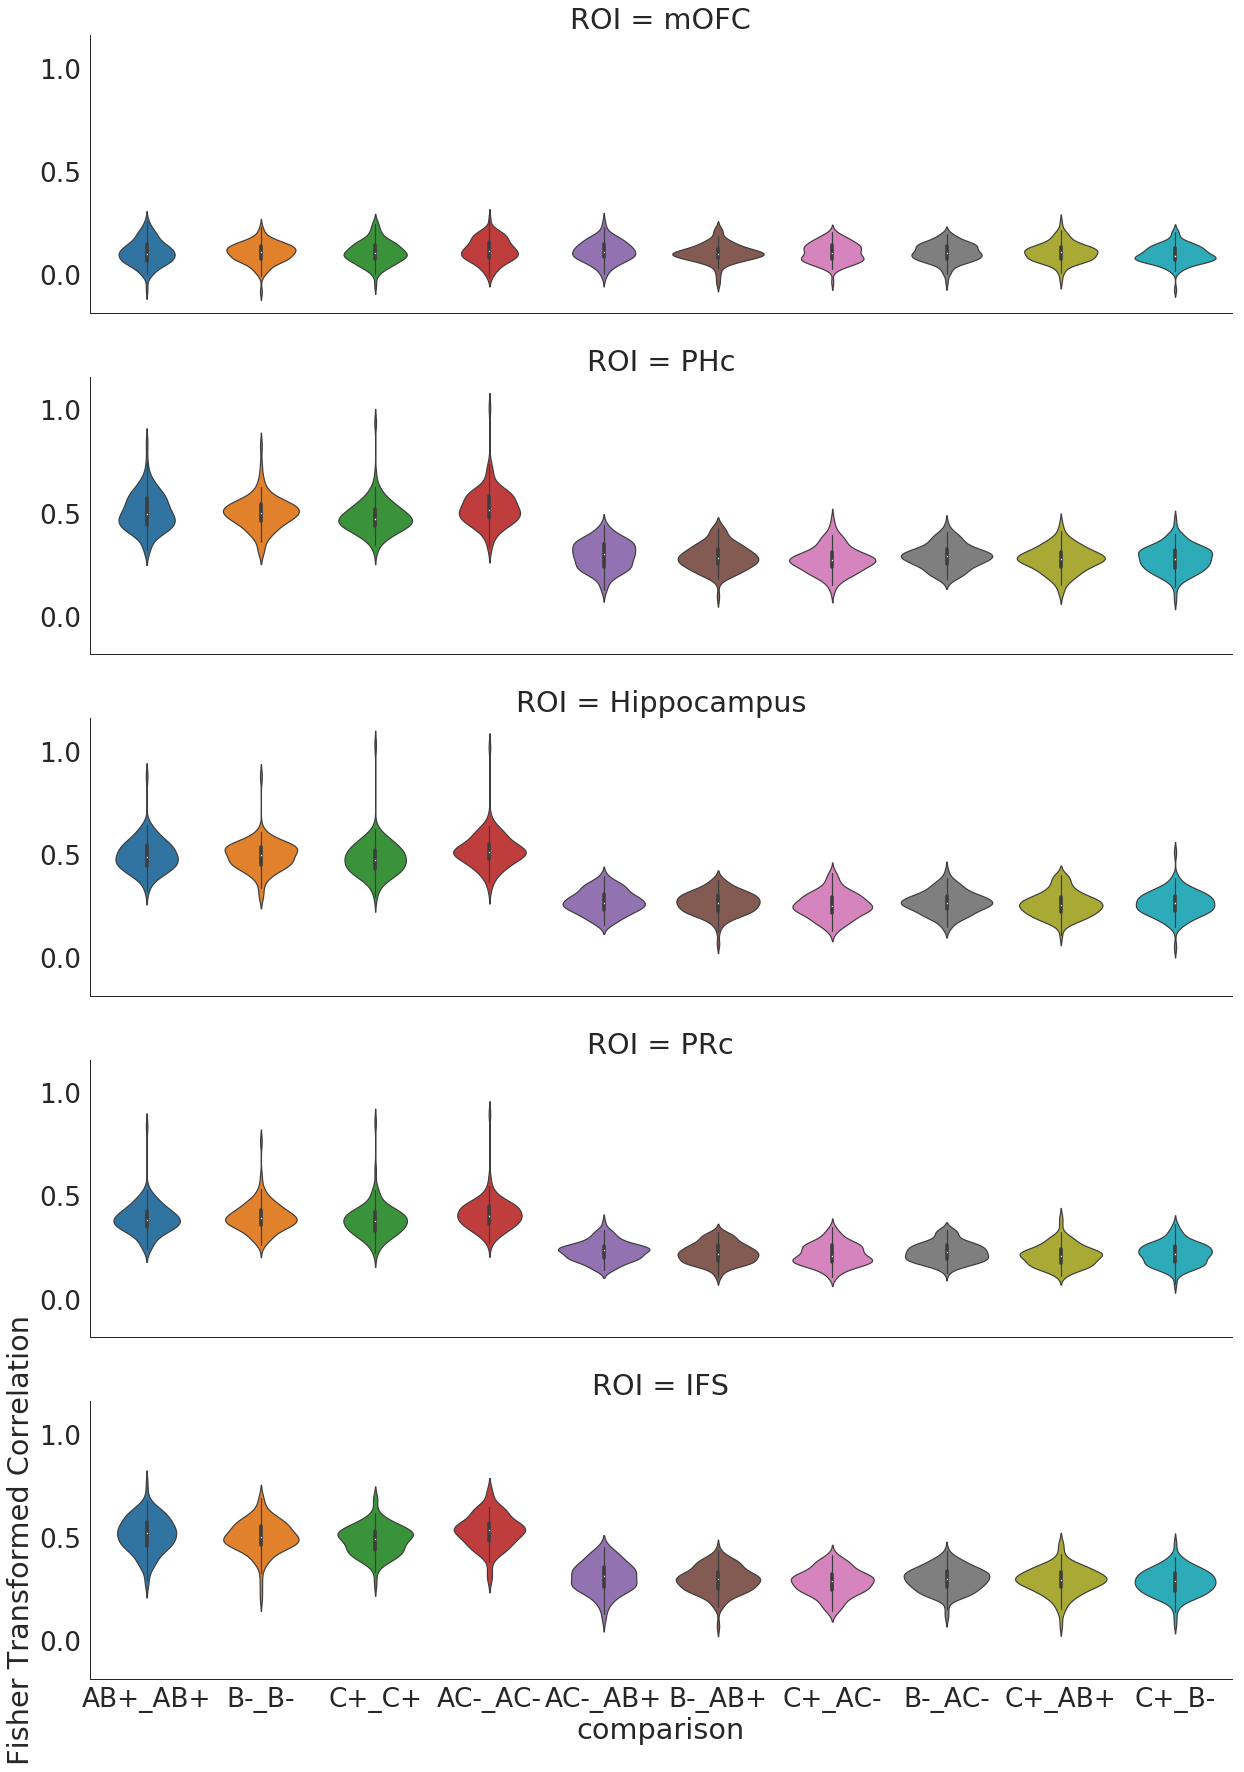

In [357]:
sns.set_context('paper',font_scale = 3)
results['ROI'] = [roi_names[x] for x in results['roi']]
results = moss.remove_unit_variance(results, 'r', 'sub', suffix="_within")
results[''] = results['r_within']

g = sns.catplot(x = 'comparison', 
            y = '',
            order = ['AB+_AB+', 'B-_B-', 'C+_C+', 'AC-_AC-', 'AC-_AB+', 'B-_AB+', 'C+_AC-', 'B-_AC-', 'C+_AB+', 'C+_B-'],
            col = 'ROI',
            kind = 'violin',
            col_wrap = 1,
            aspect = 3.5,
            data = results)
plt.ylabel('Fisher Transformed Correlation')

plt.savefig('/home/iballard/Dropbox/fd/figs/revision/condition_breakdown_id.svg', 
            dpi = 300,
           bbox_inches = 'tight')

# Load results of RL modeling

In [1]:
RL_next = pd.read_csv('/home/iballard/fdPE_V_nexttrial.csv')
RL_next = RL_next[RL_next['condition'] != 'feedback']
RL_next = RL_next.set_index(['exp','sub','run','condition'])
RL_next = RL_next.loc[('sim','fd_104')]

RL_std = pd.read_csv('/home/iballard/fdPE_V_trial.csv')
RL_std = RL_std[RL_std['condition'] != 'feedback']
RL_std = RL_std.set_index(['exp','sub','run','condition'])
RL_std = RL_std.loc[('sim','fd_104')]

for i in range(1,4):
    RL_std.loc[i,'trial'] = range(0,40)

# Conduct RSA Analysis

In [61]:
def get_base_model(sub,mask): 
    reverse_name_map = {'AB+':'b_plus','B-':'b_minus','AC-':'c_minus','C+':'c_plus'}

    overlap_pairs = [['b_plus','b_minus'],
                    ['c_plus','c_minus'],
                    ['b_plus','c_minus']]
    overlap_pairs = [set(x) for x in overlap_pairs] #so order doesnt matter
    not_overlap_pairs = [['c_plus','b_minus'],
                         ['b_plus','c_plus'],
                      ['c_minus','b_minus']]
    not_overlap_pairs = [set(x) for x in not_overlap_pairs] #so order doesnt matter


    singles = [['c_plus','c_plus'],['b_minus','c_plus'], ['b_minus','b_minus']]
    singles = [set(x) for x in singles] #so order doesnt matter
    doubles = [['b_plus','b_plus'], ['b_plus','c_minus'],['c_minus','c_minus']]     
    doubles = [set(x) for x in doubles] #so order doesnt matter
                
    #get dataframe
    sub_rsa = all_rsas.set_index(['mask','sub','run']).sort_index()
    sub_rsa = sub_rsa.loc[(mask,sub)]
    runs = set(sub_rsa.index)

    #initialize model
    model = {'response' : [],
    'valence' : [],
    'identity' : [],
    'time' : [],
    'overlap' : [],
    'value_std' : [],
    'value_next' : [],
    'pe':[],
    'run' : [], 
    'corr' : [],
    'cond1':[],
    'cond2':[]}
    

    for run in runs:
        for c1, c2, r in zip(sub_rsa.loc[run,'cond1'].values,
                             sub_rsa.loc[run,'cond2'].values,
                             sub_rsa.loc[run,'corr'].values):

            #get variables in tidy format
            cond1, trial1 = c1.split('_')
            cond2, trial2 = c2.split('_')
            cond1 = reverse_name_map[cond1]
            cond2 = reverse_name_map[cond2]

            #get reward codings
            r1 = RL_std.loc[(run,cond1),'rew'].values[int(trial1)]
            r2 = RL_std.loc[(run,cond2),'rew'].values[int(trial2)]
            same = int(r1 == r2)
            val = int(same)
            if r1 < 1.0:
                val = 0
            model['response'].append(same)
            model['valence'].append(val)

            ##identity
            iden= int(cond1 == cond2)
            model['identity'].append(iden)

            #trial diff (in real time)
            t1 = RL_std.loc[(run,cond1),'trial'].values[int(trial1)]
            t2 = RL_std.loc[(run,cond2),'trial'].values[int(trial2)]
            tdiff = abs(t1 - t2)
            model['time'].append(tdiff) 
               
            #overlap
            ov = set([cond1,cond2]) in overlap_pairs
            non_ov = set([cond1,cond2]) in not_overlap_pairs
            model['overlap'].append(int(ov) - int(non_ov))

            #value difference
            v1 = RL_std.loc[(run,cond1),'V'].values[int(trial1)]
            v2 = RL_std.loc[(run,cond2),'V'].values[int(trial2)]
            vdiff = -1 * abs(v1 - v2)
            model['value_std'].append(vdiff)
            
            #value difference
            v1 = RL_next.loc[(run,cond1),'V'].values[int(trial1)]
            v2 = RL_next.loc[(run,cond2),'V'].values[int(trial2)]
            vdiff = -1 * abs(v1 - v2)
            model['value_next'].append(vdiff)

            #PE difference
            v1 = RL_std.loc[(run,cond1),'PE'].values[int(trial1)]
            v2 = RL_std.loc[(run,cond2),'PE'].values[int(trial2)]
            vdiff = -1 * abs(v1 - v2)
            model['pe'].append(vdiff)
  
            #run
            model['run'].append(run)

            #corr
            model['corr'].append(r)

            #cond labels
            model['cond1'].append(c1)
            model['cond2'].append(c2)

    model = pd.DataFrame(model)
    return model

In [62]:
#build Data frame for modeling
base = get_base_model('fd_104','hipp')
mask_models={}
for mask in masks:
    all_models = {}

    for sub in subs:
        sub_rsa = all_rsas.set_index(['mask','sub','run'])
        sub_rsa = sub_rsa.loc[(mask,sub)]
        runs = sorted(set(sub_rsa.index))
        
        #deal with uneven number of runs
        base_runs = [1,2,3]
        sub_df = base.copy()
        if len(runs) != len(base_runs): #right number of runs
            bad_runs = set(runs) ^ set(base_runs)
            for bad_run in bad_runs:
                sub_df = sub_df[sub_df['run'] != bad_run]
        all_models[sub] = sub_df

        corr = []
        for run in runs:
            r = sub_rsa.loc[run]['corr'].values
            corr.extend(r)
            
        all_models[sub]['corr'] = corr

    mask_models[mask] = dict(all_models)

/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  if __name__ == '__main__':


Text(0.5,1,'identity')

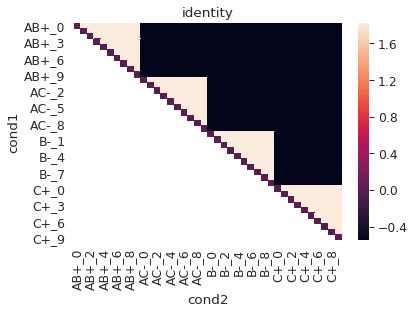

In [63]:
#Visualize regressors for the model of the RSA matrix
tmp  = mask_models['hipp']['fd_104'].copy()
tmp = tmp[tmp['run'] ==3]


x_var = 'identity'
tmp[x_var] = scipy.stats.zscore(tmp[x_var])
# tmp[x_var] = vector_reject(tmp[x_var].values, tmp['valence'].values)

sns.set_context('paper',font_scale = 1.4,rc={"figure.figsize": (20, 20)})
sns.set_style("white")


tmp = tmp[['cond1','cond2',x_var]]
new_df = pd.DataFrame()
for cond in ['AB+_','B-_','AC-_','C+_']:
    for i in range(10):
        row = pd.DataFrame({x_var:0,
                            'cond1':cond + str(i),
                            'cond2':cond + str(i)},index = [0])
        new_df = new_df.append(row)
tmp = pd.concat([tmp,new_df])
tmp = tmp.groupby(['cond1','cond2']).mean().unstack()[x_var]
sns.heatmap(tmp)
plt.title(x_var)
# plt.savefig('/home/iballard/Dropbox/fd/figs/committee_meeting/model_' + x_var +'.svg',dpi = 600)

# Deal with screen order

In [390]:
screen_order = pd.read_csv(op.join('/home','iballard','Dropbox','fd','sim_screen_order.csv'))
screen_order = screen_order.set_index(['sub','run','cond'])
for row in set(screen_order.index):
    screen_order.loc[row,'cond_num'] = map(int,np.arange(10))
screen_order = screen_order.reset_index()
screen_order['condition'] = [name_map[x] + str(int(c)) for x,c in zip(screen_order['cond'].values,
                                                                       screen_order['cond_num'].values)]
screen_order = screen_order.set_index(['sub','run']).sort_index()

In [391]:
screen_rsa = {'cond1':[],'cond2':[],'different_hemi':[],'run':[],'sub':[]}

for row in set(screen_order.index):
    
    sub,run = row
    sub_df = screen_order.loc[row].set_index('condition').sort_index()
    
    for trial1 in set(sub_df.index):
        for trial2 in set(sub_df.index):
            
            cond1 = sub_df.loc[trial1,'cond']
            cond2 = sub_df.loc[trial2,'cond']
            lr1 = sub_df.loc[trial1,'lr']
            lr2 = sub_df.loc[trial2,'lr']
            cond_set = set([cond1,cond2]) #useful so order doesnt matter
            
            diff = False
            if cond1 == cond2 and lr1 != lr2:
                diff = True
            if cond_set in [set(['b_plus','c_minus'])] and lr1 != lr2:
                diff = True
            if cond_set in [set(['b_plus','c_plus']),set(['c_minus','b_minus']),set(['b_minus','c_plus'])]:
                diff = True
            if cond_set in [set(['b_plus','b_minus']),set(['c_minus','c_plus'])] and lr1 == lr2:
                diff = True
            
            screen_rsa['different_hemi'].append(diff)
            screen_rsa['sub'].append(sub)
            screen_rsa['run'].append(run)
            screen_rsa['cond1'].append(trial1)
            screen_rsa['cond2'].append(trial2)
screen_rsa = pd.DataFrame(screen_rsa)
screen_rsa.to_csv(home_dir + '/screen_order.csv',index = False)
screen_rsa = screen_rsa.sort_values(by = ['sub','run','cond1','cond2']).set_index('sub')

In [392]:
screen_rsa = pd.read_csv(home_dir + '/screen_order.csv')
screen_rsa = screen_rsa.sort_values(by = ['sub','run','cond1','cond2']).set_index('sub')

# Build linear model

In [450]:
value_regressors = ['value_next','pe']
regressors = ['response','valence','identity','overlap','pe','value_std','value_next','time','time2','run']

model = []
for mask_idx,mask in enumerate(masks):
    #deal with time
    for n,sub in enumerate(subs):
        m = mask_models[mask][sub].copy()
        
#         #add in info about screen location
#         m = pd.merge(screen_rsa.loc[sub],
#          m,
#          how = 'inner')
#         m = m[m['different_hemi'] == True] #subsample to only look at different hemispheres
        
        m['time'] = scipy.stats.zscore(m['time'])
        m['time2'] = [x**2 for x in m['time']]
        
        #standardize regressors
        for r in regressors:
            if r not in ['run','different_hemi']: #categorical
                m[r] = scipy.stats.zscore(m[r])
        
        #subjects
        m['sub'] = sub
        m['mask'] = mask
        
        #clean up dataframe
        all_cols = list(regressors)
        all_cols.extend(['corr','sub','mask'])

        epoch = []
        for c1,c2 in zip(m['cond1'], m['cond2']):
            c1_trial = int(c1.split('_')[1])
            c2_trial = int(c2.split('_')[1])
            if c1_trial < 5 and c2_trial < 5:
                epoch.append(-1)
            elif c1_trial > 5 and c2_trial > 5:
                epoch.append(1)
            else:
                epoch.append(0)
        m['epoch'] = epoch
        
        #orthogonalize
        for v_regress in value_regressors:
            if v_regress in regressors:
                m[v_regress] = vector_reject(m[v_regress],m['response'])
                m[v_regress] = vector_reject(m[v_regress],m['valence'])

       
        #process y
        m['corr'] = map(np.arctanh,m['corr'])
        model.append(m.copy())
        
model = pd.concat(model)
model['roi'] = [roi_names[x] for x in model['mask']]

#set up model
model_str = ['corr ~ 1']
for r in regressors:
    model_str.append(r)
model_str = '+'.join(model_str)
print model_str

corr ~ 1+response+valence+identity+overlap+pe+value_std+value_next+time+time2+run


# Run Permutations

In [264]:
model = model.reset_index().set_index(['mask','sub'])

In [372]:
def permute_data(permuation_number):
    shuffled_params = pd.DataFrame()
    
    #loop through masks and subjects
    for row in set(model.index):
        df = model.loc[row].copy()

        #shuffle
        df['corr'] = np.random.permutation(df['corr'])

        #fit model
        model_str = 'corr ~ 1 + response + valence + time2 + pe + epoch + overlap + time*identity + C(run,Sum)'
        fit = ols(model_str,df).fit()

        #compile results
        new_data = fit.params
        new_data['sub'] = str(row[1])
        new_data['mask'] = row[0]
        shuffled_params = shuffled_params.append(new_data, ignore_index = True)
    
    #save data
    out_f = op.join(op.abspath('/home/iballard/fd/permutation/revision'),'shuffled_' + str(permuation_number) + '.csv')
    shuffled_params.to_csv(out_f,index = False)

In [267]:
# dview = rc[0:52]
# dview.block = True

# dview.push(dict(home_dir=home_dir,
#                 model = model,
#                   ))
# dview.execute("import numpy as np")
# dview.execute("import os.path as op")
# dview.execute("import pandas as pd")
# with dview.sync_imports():
#     import os
#     import numpy
#     import scipy
#     import scipy.stats
#     from statsmodels.formula.api import ols
# n_permutations = 10000
# dview.map_sync(permute_data,np.arange(n_permutations))

# Conduct permutation test

In [661]:
# loop through masks and subjects
model = model.reset_index().set_index(['mask','sub','run']).sort_index()
fit_params = pd.DataFrame()
for row in set(model.index):
    df = model.loc[row].copy()
    
    #fit model
    model_str = 'corr ~ 1 + response + valence + time2 + pe + value_next + overlap + time*identity'
    fit = ols(model_str,df).fit()

    #compile resprint ults
    new_data = fit.params
    new_data['sub'] = str(row[1])
    new_data['mask'] = row[0]
    new_data['run'] = row[2]
    fit_params = fit_params.append(new_data, ignore_index = True)
fit_params.to_csv('/home/iballard/Dropbox/fd/fit_params.csv',index = False)
fit_params['roi'] = [roi_names[x] for x in fit_params['mask']]

In [656]:
# loop through masks and subjects
model = model.reset_index().set_index(['mask','sub']).sort_index()
fit_params = pd.DataFrame()
for row in set(model.index):
    df = model.loc[row].copy()
    
    #fit model
    model_str = 'corr ~ 1 + response + valence + time2 + pe + value_next*epoch + overlap + time*identity + C(run,Sum)'
    fit = ols(model_str,df).fit()

    #compile resprint ults
    new_data = fit.params
    new_data['sub'] = str(row[1])
    new_data['mask'] = row[0]
    fit_params = fit_params.append(new_data, ignore_index = True)
fit_params = fit_params[fit_params['mask'] != 'V1']
# fit_params = fit_params.groupby('mask').mean().reset_index()
fit_params['roi'] = [roi_names[x] for x in fit_params['mask']]

In [657]:
fit_params.to_csv('/home/iballard/Dropbox/fd/paper/data/fit_params_epoch.csv')

In [2]:
sns.set_context('paper',font_scale = 2.5)
a4_dims = (10,6)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxenplot(x = 'roi', y = 'identity', data = fit_params,
             order = ['Hippocampus','PHc', 'PRc', 'IFS','mOFC'],
              dodge = .1,  ax = ax)

sns.despine()
plt.ylabel('Pattern Similarity\n(Beta [Fisher(r)])')
plt.xlabel('')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
# plt.savefig('/home/iballard/Dropbox/fd/figs/revision2/identity_diff.png', 
#             dpi = 400,
#            bbox_inches = 'tight')

In [268]:
#load data
n_permutations = 10000
shuffled_params = []
for permuation_number in range(n_permutations):
    out_f = op.join(op.abspath('../fd/permutation/revision/'),'shuffled_' + str(permuation_number) + '.csv')
    df = pd.read_csv(out_f)
    df['sample'] = permuation_number
    shuffled_params.append(df)
shuffled_params = pd.concat(shuffled_params)
shuffled_params = shuffled_params[shuffled_params['mask'] != 'V1']
shuffled_params = shuffled_params.groupby(['mask','sample']).mean().reset_index()
shuffled_params['roi'] = [roi_names[x] for x in shuffled_params['mask']]

In [454]:
def get_p_value(shuffled_params,fit_params,regressor):
    p_values = {'mask':[],'p':[]}
    for m in set(fit_params['mask']):
        p_values['mask'].append(m)
        if regressor == 'value_std':
            shuff = shuffled_params.set_index('mask').loc[m,'value_next']

        else:
            shuff = shuffled_params.set_index('mask').loc[m,regressor]

        val = fit_params.set_index('mask').loc[m,regressor]
        
        p = sum(shuff > val)/float(len(shuff))
        if p > .5:
            p = 1 - p
        p_values['p'].append(p)


    p_values = pd.DataFrame(p_values)
    sig,pcorr = fdrcorrection(p_values['p'],.05)
    p_values['p_corr'] = pcorr
    return p_values

,mask,p,p_corr
0,mOFC_fill_sim,0.0000,0.00000
1,peri_sim,0.0076,0.00950
2,hipp,0.2543,0.25430
3,para_sim,0.0054,0.00900
4,yeo17_ifs,0.0001,0.00025


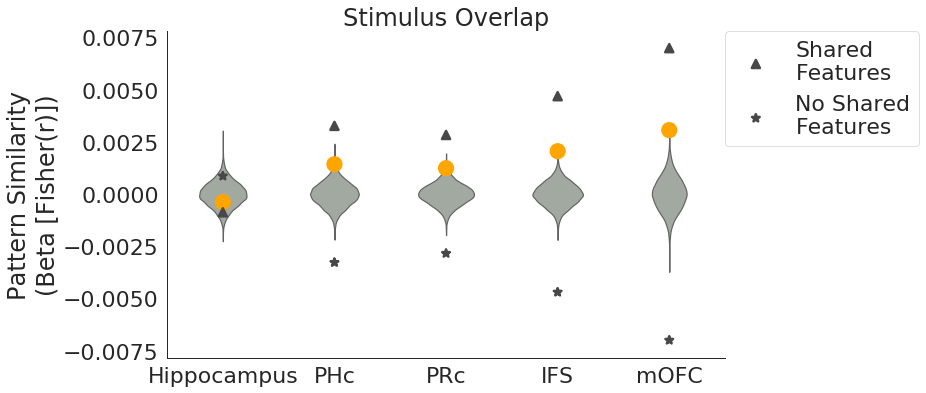

In [637]:
regressor = 'overlap'


a4_dims = (10,6)
fig, ax = plt.subplots(figsize=a4_dims)

ax = sns.violinplot(x = 'roi',y= regressor,
               data = shuffled_params, 
                    order = ['Hippocampus','PHc', 'PRc', 'IFS','mOFC'],
                    width = .5,
               color = '#9faf9a',
                    markers = 'x',
                    saturation = .4,
                   inner = None,
                   ax = ax)
sns.pointplot(x = 'roi',y = regressor,
              data = fit_params,
             order = ['Hippocampus','PHc', 'PRc', 'IFS','mOFC'],
              color = 'orange',
              legend = True,
              join = False, 
              scale = 2.3,
              ax = ax)
sns.pointplot(x = 'roi', y = 'beta', hue = '', data = run_df,
              join = False,
              markers=["^", "*"],
              palette = ['#484848','#484848'],
              scale = 1.5,
             order = ['Hippocampus','PHc', 'PRc', 'IFS','mOFC'],
              dodge = 0,  ax = ax)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

sns.despine()
plt.ylabel('Pattern Similarity\n(Beta [Fisher(r)])')
plt.xlabel('')
# plt.title('Value (Target Predictiveness)')# by Epoch (Late versus Early)')
plt.title('Stimulus Overlap')

sns.set_context('paper',font_scale = 2.5)
plt.savefig('/home/iballard/Dropbox/fd/figs/revision2/permutation_' + regressor +'.svg', 
            dpi = 300,
           bbox_inches = 'tight')
sns.set_style({'font.family': 'Times New Roman'})
get_p_value(shuffled_params,fit_params,regressor)

In [396]:
for regressor in ['identity','overlap']:
    for other_mask in ['peri_sim','para_sim','yeo17_ifs','mOFC_fill_sim']:
        diff = fit_params.set_index('mask').loc['hipp',regressor] -  fit_params.set_index('mask').loc[other_mask,regressor]
        shuffled_differences = shuffled_params.set_index('mask').loc['hipp',regressor].values - shuffled_params.set_index('mask').loc[other_mask,regressor].values
        if regressor == 'identity':
            p = 1 - sum(diff > shuffled_differences)/10000.0
        else:
            p = sum(diff > shuffled_differences)/10000.0
        print regressor, other_mask, p

identity peri_sim 0.0
identity para_sim 0.0
identity yeo17_ifs 0.0
identity mOFC_fill_sim 0.0
overlap peri_sim 0.0281
overlap para_sim 0.0101
overlap yeo17_ifs 0.0013
overlap mOFC_fill_sim 0.0008
